In [ ]:
# Risk Analysis Dashboard
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]

from src.data import DataLoader, PortfolioConfig
from src.risk import RiskManager, RiskConfig
from src.visualization import RiskVisualizer

# 1. Configure and Load Data
portfolio_config = PortfolioConfig(
    tickers=['NVDA', 'AMD', 'INTC'],
    weights=[0.4, 0.4, 0.2],
    start_date='2023-01-01',
    end_date='2024-01-01'
)

# Load market data
loader = DataLoader(portfolio_config)
market_data = loader.load_stocks()

# 2. Risk Analysis
risk_config = RiskConfig(
    confidence_level=0.95,
    max_drawdown_limit=0.20,
    volatility_target=0.15
)

risk_manager = RiskManager(risk_config)
risk_metrics = risk_manager.calculate_metrics(market_data['returns'])

# 3. Create Visualization Dashboard
visualizer = RiskVisualizer()
dashboard = visualizer.create_risk_dashboard(market_data, risk_metrics)
plt.show()

# 4. Print Risk Metrics
print("\nRisk Metrics Summary:")
print("=" * 50)
print(f"Portfolio Volatility: {risk_metrics['portfolio_volatility']:.2%}")
print(f"VaR (95%): {risk_metrics['var_95']:.2%}")
print(f"Expected Shortfall (95%): {risk_metrics['expected_shortfall_95']:.2%}")
print(f"Max Drawdown: {risk_metrics['max_drawdown']:.2%}")
print(f"Sharpe Ratio: {risk_metrics['sharpe_ratio']:.2f}")

Loading data for NVDA, AMD, INTC, ^IXIC...

Loading data for NVDA, AMD, INTC, ^IXIC...


/Users/lucas/Documents/GitHub/project-datascience/src/risk.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (cum_returns[-1] / peak[-1]) - 1
/Users/lucas/Documents/GitHub/project-datascience/src/risk.py:166: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'worst_month': returns.groupby(pd.Grouper(freq='M')).sum().min(),
/Users/lucas/Documents/GitHub/project-datascience/src/risk.py:167: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  'worst_quarter': returns.groupby(pd.Grouper(freq='Q')).sum().min(),


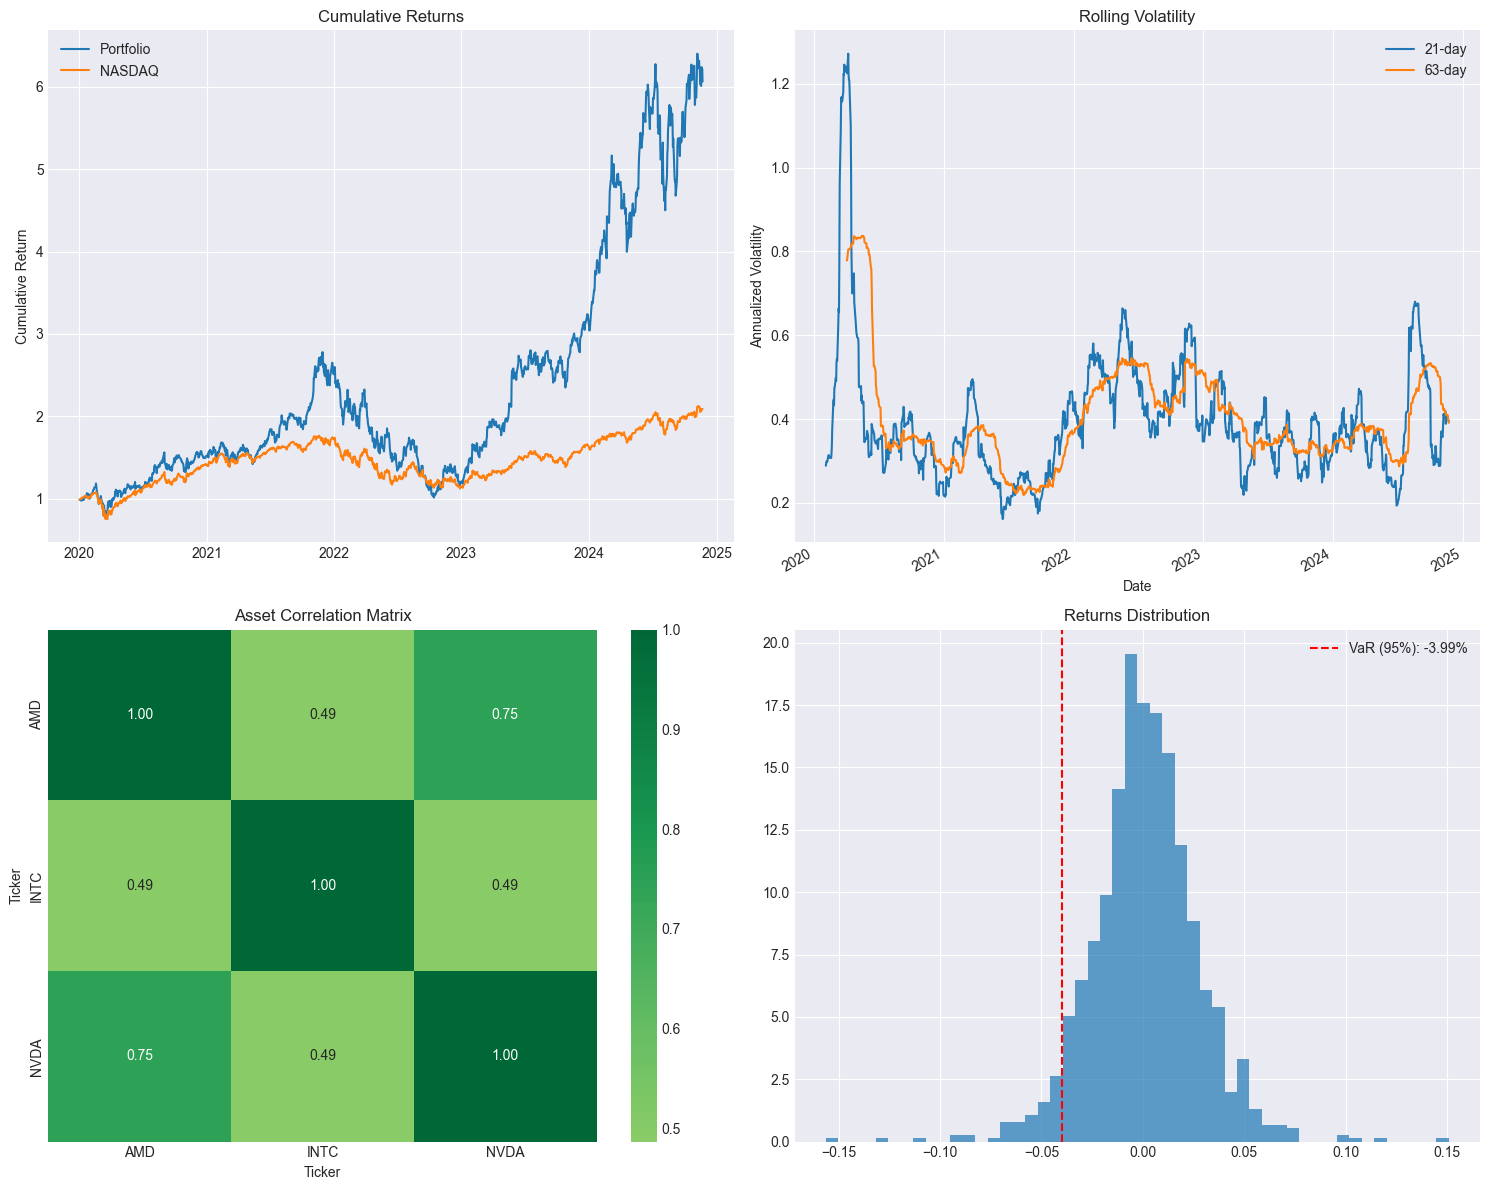


Risk Metrics Summary:
Portfolio Volatility: 42.72%
VaR (95%): -3.99%
Expected Shortfall (95%): -5.74%
Max Drawdown: -59.51%
Sharpe Ratio: 0.73

Risk Regime Analysis:

Low Vol Regime:
Average Monthly Return: 4.36%
Volatility: 26.10%
% of Time: 32.5%

Medium Vol Regime:
Average Monthly Return: 2.81%
Volatility: 37.00%
% of Time: 33.4%

High Vol Regime:
Average Monthly Return: -0.25%
Volatility: 57.06%
% of Time: 32.5%

Performance Statistics:
Total Return: 506.27%
Annualized Return: 44.57%
Risk-Adjusted Return (Sharpe): 0.73


/var/folders/1v/b3g8y1js0jn8s0bmf5sypcjh0000gn/T/ipykernel_1923/3868788872.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = portfolio_cum_returns[-1] - 1


In [2]:
# Enhanced Risk Analysis Dashboard
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [15, 10]

from src.data import DataLoader, PortfolioConfig
from src.risk import RiskManager, RiskConfig
from src.visualization import RiskVisualizer

# 1. Configure and Load Data
portfolio_config = PortfolioConfig(
    tickers=['NVDA', 'AMD', 'INTC', '^IXIC'],
    weights=[0.4, 0.4, 0.2, 0],
    start_date='2020-01-01',
    end_date='2024-11-25'
)

# Load market data
print(f"Loading data for {', '.join(portfolio_config.tickers)}...")
loader = DataLoader(portfolio_config)
market_data = loader.load_stocks()

# 2. Risk Analysis with simplified config
risk_config = RiskConfig(
    confidence_level=0.95,
    max_drawdown_limit=0.20,
    volatility_target=0.15
)

# Initialize RiskManager with weights
risk_manager = RiskManager(
    config=risk_config,
    risk_free_rate=0.05,
    weights=portfolio_config.weights[:-1]  # Exclude benchmark weight
)

# Calculate risk metrics for portfolio returns only (excluding benchmark)
portfolio_returns = market_data['returns'].iloc[:, :-1]  # Exclude benchmark
risk_metrics = risk_manager.calculate_metrics(portfolio_returns)

# 3. Create Visualization Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Cumulative Returns
cum_returns = (1 + market_data['returns']).cumprod()
portfolio_cum_returns = cum_returns.iloc[:, :-1].dot(portfolio_config.weights[:-1])
ax1.plot(cum_returns.index, portfolio_cum_returns, label='Portfolio')
ax1.plot(cum_returns.index, cum_returns['^IXIC'], label='NASDAQ')
ax1.set_title('Cumulative Returns')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True)

# Plot 2: Rolling Volatility
rolling_vol = risk_metrics['rolling_volatility']
rolling_vol.plot(ax=ax2)
ax2.set_title('Rolling Volatility')
ax2.set_ylabel('Annualized Volatility')
ax2.legend(['21-day', '63-day'])
ax2.grid(True)

# Plot 3: Correlation Matrix
sns.heatmap(risk_metrics['correlation'],
            annot=True,
            cmap='RdYlGn',
            center=0,
            fmt='.2f',
            ax=ax3)
ax3.set_title('Asset Correlation Matrix')

# Plot 4: Returns Distribution
returns = portfolio_returns.dot(portfolio_config.weights[:-1])
ax4.hist(returns, bins=50, density=True, alpha=0.7)
ax4.axvline(risk_metrics['var_95'], color='r', linestyle='--', 
            label=f"VaR (95%): {risk_metrics['var_95']:.2%}")
ax4.set_title('Returns Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# 4. Print Risk Analysis
print("\nRisk Metrics Summary:")
print("=" * 50)
print(f"Portfolio Volatility: {risk_metrics['portfolio_volatility']:.2%}")
print(f"VaR (95%): {risk_metrics['var_95']:.2%}")
print(f"Expected Shortfall (95%): {risk_metrics['expected_shortfall_95']:.2%}")
print(f"Max Drawdown: {risk_metrics['max_drawdown']:.2%}")
print(f"Sharpe Ratio: {risk_metrics['sharpe_ratio']:.2f}")

# 5. Risk Regime Analysis
vol_quantiles = rolling_vol['21d'].quantile([0.33, 0.67])
risk_regimes = pd.cut(rolling_vol['21d'], 
                     bins=[-np.inf, vol_quantiles.iloc[0], 
                           vol_quantiles.iloc[1], np.inf],
                     labels=['Low Vol', 'Medium Vol', 'High Vol'])

print("\nRisk Regime Analysis:")
print("=" * 50)
for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
    regime_returns = returns[risk_regimes == regime]
    print(f"\n{regime} Regime:")
    print(f"Average Monthly Return: {regime_returns.mean() * 21:.2%}")
    print(f"Volatility: {regime_returns.std() * np.sqrt(252):.2%}")
    print(f"% of Time: {(risk_regimes == regime).mean():.1%}")

# 6. Performance Statistics
print("\nPerformance Statistics:")
print("=" * 50)
total_return = portfolio_cum_returns[-1] - 1
annualized_return = (1 + total_return) ** (252/len(returns)) - 1
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Risk-Adjusted Return (Sharpe): {risk_metrics['sharpe_ratio']:.2f}")